# Race Time Non-parametric Regression
Spring 2019 AME-70790 Final Project

Nicholas Geneva (ngeneva@nd.edu)

Reference: Wand, M. P., & Jones, M. C. (1994). Kernel smoothing. Chapman and Hall/CRC.
___
As an application of the local polynomial regression techniques we have learned, we will look at the prediction of record [Scottish hill race times](http://www.scottishhillracing.co.uk/).
Hill running, also known as fell running, is an off-road running competition over upland country where the gradient climbed is a significant component of the race difficulty.
Such races occur all around the *hilly* terrain of Scotland.
The goal of this data will be to predict record race times for male and female competitors given the total distance of the race and the elevation climbed.
The data consists of 77 different races from 2000 and was provided by the [Rdatasets library](https://vincentarelbundock.github.io/Rdatasets/datasets.html).

The data has already been preprocessed into a numpy array that contains race length (miles), elevation (feet), record male time (hours) and record female time (hours) for each entry.
Null timing values are represented by a negative number.

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import multivariate_normal
from IPython.display import display
from mpl_toolkits.mplot3d import Axes3D

In [10]:
plt.close("all")
np.random.seed(123)

# Load data and create pandas datafram
data = np.load('data/race_2000_data.npy')
data_m = data[:,:3]
data_f = np.delete(np.delete(data, np.where(data[:,3] < 0), 0), 2, 1) # Remove null values in female data
dataset = pd.DataFrame({'Length (mi)':data[:,0].astype(int),'Elevation (ft)':data[:,1],\
                        'Time Male (hr)':data[:,2], 'Time Female (hr)':data[:,3]})
with pd.option_context('display.max_rows',7):
    display(dataset)

,Length (mi),Elevation (ft),Time Male (hr),Time Female (hr)
0,2,2000.0,0.403611,0.518889
1,2,650.0,0.254444,0.316667
2,3,750.0,0.485833,0.389167
...,...,...,...,...
74,3,650.0,0.358056,0.442500
75,2,2000.0,0.387222,0.518889
76,2,650.0,0.254444,0.316667


For simplicity we will use multivariate local linear regression with the loss function:
    $$\mathcal{L} = \sum_{i=1}^{n}\left(t_{i}-\beta_{0} + \beta_{1}(x_{i}-x) + \beta_{2}(y_{i}-y)\right)^{2}K_{h}(x_{i}-x, y_{i}-y),$$
where the inputs are the length of the race and elevation change.
We will once again use the standard multivariate Gaussian kernel:
    $$K(\textbf{x})=\mathcal{N}(\textbf{x}|0,H), \quad H=\left[\begin{matrix} 5 & 0 \\ 0 & 5e5 \end{matrix}\right].$$
Large bandwidths had to be used due to the sparseness of the data.

In [86]:
H = np.array([[5,0],[0,5e5]]) # Kernel Bandwidth

# Predict
n_pred = 50
length = np.linspace(2, 10, n_pred)
elev = np.linspace(500, 3000, n_pred)
x1, x2 = np.meshgrid(length, elev)
x_pred = np.stack([np.reshape(x1, (-1)), np.reshape(x2, (-1))], axis=0)
betas_m = np.zeros((3,x_pred.shape[1]))
betas_f = np.zeros((3,x_pred.shape[1]))
# Predict male times
for i, x0 in enumerate(x_pred.T):
    # Male time
    X = np.stack([np.ones(data_m.shape[0]), data_m[:,0]-x0[0], data_m[:,1]-x0[1]], axis=1)
    W = np.diag(multivariate_normal.pdf(data_m[:,:2]-x0, cov=H))
    # Add a little jitter to the matrix to ensure invertability
    betas_m[:,i] = np.linalg.inv(X.T.dot(W).dot(X) + 1e-7*np.eye(X.shape[1])).dot(X.T).dot(W).dot(data_m[:,2])
    
    # Female time
    X = np.stack([np.ones(data_f.shape[0]), data_f[:,0]-x0[0], data_f[:,1]-x0[1]], axis=1)
    W = np.diag(multivariate_normal.pdf(data_f[:,:2]-x0, cov=H))
    betas_f[:,i] = np.linalg.inv(X.T.dot(W).dot(X) + 1e-7*np.eye(X.shape[1])).dot(X.T).dot(W).dot(data_f[:,2])

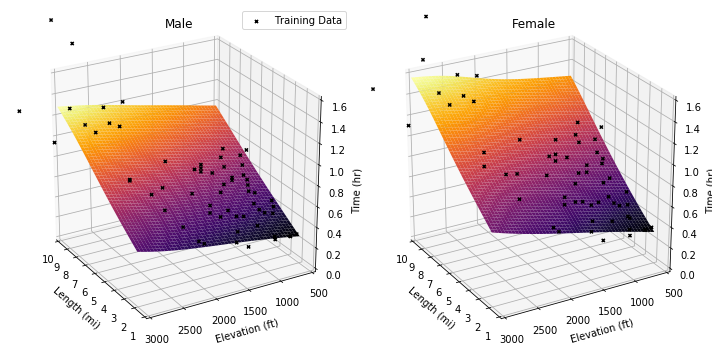

In [89]:
fig = plt.figure(figsize=(10,5))
ax = []
ax.append(plt.subplot2grid((1, 2), (0, 0), projection='3d'))
ax.append(plt.subplot2grid((1, 2), (0, 1), projection='3d'))

zpred = np.reshape(betas_m[0], (n_pred, n_pred))
ax[0].plot_surface(x1, x2,  zpred, cmap=cm.inferno, alpha=1.0)
ax[0].scatter(data_m[:,0], data_m[:,1], data_m[:,2], s=10, c='k', marker='x', alpha=1.0, label='Training Data')

zpred = np.reshape(betas_f[0], (n_pred, n_pred))
ax[1].plot_surface(x1, x2,  zpred, cmap=cm.inferno, alpha=1.0)
ax[1].scatter(data_f[:,0], data_f[:,1], data_f[:,2], s=10, c='k', marker='x', alpha=1.0)

for ax0 in ax:
    ax0.view_init(elev=25., azim=150)
    ax0.set_xlabel('Length (mi)')
    ax0.set_ylabel('Elevation (ft)')
    ax0.set_zlabel('Time (hr)')
    ax0.set_xlim([1,10])
    ax0.set_ylim([500, 3000])
    ax0.set_zlim([0, 1.6])

ax[0].set_title('Male')
ax[0].legend()
ax[1].set_title('Female')
plt.tight_layout()
plt.show()

(Left to right) The male regression model prediction with the training points and the female time regression model with training points.
Since a large band with had to be used, the results are very smooth however the predicted trend is what is expected.